**ноутбук с обучением модели**

In [1]:
from math import *
import random

In [2]:
class Value:
  def __init__(self, data, _children=(), _op=''):
    self.data = float(data)
    self.grad = 0.0
    self._backward_fn = lambda: None
    self._prev = set(_children)

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    res = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * res.grad
      other.grad += 1.0 * res.grad

    res._backward_fn = _backward
    return res

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    res = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * res.grad
      other.grad += self.data * res.grad

    res._backward_fn = _backward
    return res

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    res = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other - 1)) * res.grad

    res._backward_fn = _backward
    return res

  def exp(self):
    res = Value(exp(self.data), (self, ), 'exp')

    def _backward():
      self.grad += res.data * res.grad

    res._backward_fn = _backward
    return res

  def relu(self):
    res = Value(self.data if self.data > 0 else 0, (self, ), 'ReLU')

    def _backward():
      self.grad += (1.0 if self.data > 0 else 0) * res.grad

    res._backward_fn = _backward
    return res

  def log(self):
    import math
    res = Value(math.log(self.data), (self, ), 'log')

    def _backward():
      self.grad += (1.0 / self.data) * res.grad

    res._backward_fn = _backward
    return res


  def __truediv__(self, other): return self * (other**-1)
  def __sub__(self, other): return self + (other * -1)
  def __radd__(self, other): return self + other
  def __rmul__(self, other): return self * other

  def backward(self):
    tp = list()
    visited = set()

    def f(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          f(child)
        tp.append(v)
    f(self)
    self.grad = 1.0
    for node in reversed(tp):
      node._backward_fn()


In [3]:
def sum_vectors(v1, v2):
    return [a + b for a, b in zip(v1, v2)]

def matvec_prod(vector, matrix):
    res = [Value(0.0) for _ in range(len(matrix[0]))]
    for j in range(len(matrix[0])):
        for i in range(len(matrix)):
            res[j] = res[j] + vector[i] * matrix[i][j]
    return res

def dot_product(v1, v2):
    return sum((a * b for a, b in zip(v1, v2)), Value(0.0))

In [4]:
class Normalization:
    def __init__(self, d):
        self.gamma = [Value(1.0) for _ in range(d)]
        self.beta = [Value(0.0) for _ in range(d)]
        self.eps = 1e-5

    def __call__(self, X):
        ans = list()
        for x in X:
            mu = sum(x, Value(0.0)) / len(x)
            var = sum(((xi - mu)**2 for xi in x), Value(0.0)) / len(x)
            std = (var + self.eps)**0.5
            ans.append([(xi - mu) / std * g + b for xi, g, b in zip(x, self.gamma, self.beta)])
        return ans

    def parameters(self): return self.gamma + self.beta

In [5]:
class FeedForwardLayer:
    def __init__(self, d, ffl_dim):
        self.W1 = [[Value(random.uniform(-0.1, 0.1)) for _ in range(ffl_dim)] for _ in range(d)]
        self.b1 = [Value(0.0) for _ in range(ffl_dim)]
        self.W2 = [[Value(random.uniform(-0.1, 0.1)) for _ in range(d)] for _ in range(ffl_dim)]
        self.b2 = [Value(0.0) for _ in range(d)]

    def __call__(self, X):
        return [sum_vectors(matvec_prod([h.relu() for h in sum_vectors(matvec_prod(x, self.W1), self.b1)], self.W2), self.b2) for x in X]

    def parameters(self):
        return [p for m in [self.W1, self.W2] for r in m for p in r] + self.b1 + self.b2

In [6]:
class QKVAttention:
    def __init__(self, head_count, d):
        self.d = d
        self.head_count = head_count
        self.W_q = [[[Value(random.uniform(-0.1, 0.1)) for _ in range(d)] for _ in range(d)] for _ in range(head_count)]
        self.W_k = [[[Value(random.uniform(-0.1, 0.1)) for _ in range(d)] for _ in range(d)] for _ in range(head_count)]
        self.W_v = [[[Value(random.uniform(-0.1, 0.1)) for _ in range(d)] for _ in range(d)] for _ in range(head_count)]

    def softmax(self, scores):
        m = max(s.data for s in scores)
        exps = [(s - m).exp() for s in scores]
        summ = sum(exps, Value(0.0))
        return [e / summ for e in exps]

    def __call__(self, X):
        ans = list()
        for i in range(len(X)):
            head = list()
            for h in range(self.head_count):
                q = matvec_prod(X[i], self.W_q[h])
                K = [matvec_prod(X[j], self.W_k[h]) for j in range(i + 1)]
                V = [matvec_prod(X[j], self.W_v[h]) for j in range(i + 1)]

                weights = self.softmax([dot_product(q, k) / (self.d**0.5) for k in K])

                a = [Value(0.0) for _ in range(self.d)]
                for j, w in enumerate(weights):
                    a = sum_vectors(a, [v * w for v in V[j]])
                head.append(a)

            A = head[0]
            for h in range(1, self.head_count):
                A = sum_vectors(A, head[h])
            ans.append(A)
        return ans

    def parameters(self):
        return [p for heads in [self.W_q, self.W_k, self.W_v] for mat in heads for row in mat for p in row]

In [7]:
class PositionalEncoding:
    def __init__(self, d, max_len=500):
        self.pe = list()
        for pos in range(max_len):
            row = list()
            for i in range(d):
                if i % 2 == 0: row.append(sin(pos / (10000 ** (i / d))))
                else: row.append(cos(pos / (10000 ** ((i - 1) / d))))
            self.pe.append(row)

    def __call__(self, X):
        res = list()
        for i, x in enumerate(X):
            row = [xi + pi for xi, pi in zip(x, self.pe[i])]
            res.append(row)
        return res

In [8]:
class Embedding:
    def __init__(self, v_size, d):
        self.W = [[Value(random.uniform(-0.1, 0.1)) for _ in range(d)] for _ in range(v_size)]
    def __call__(self, X):
        return [[Value(w.data, (w,)) for w in self.W[x]] for x in X]
    def parameters(self): return [p for r in self.W for p in r]

In [9]:
class Dropout:
    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, X, training=True):
        if not training:
            return X
        res = list()
        for x in X:
            mask = 0 if random.random() < self.p else 1
            res.append([xi * mask for xi in x])
        return res

In [10]:
class DecoderBlock:
    def __init__(self, token_len, head_count, ffl_dim, dropout_rate):
        self.attention = QKVAttention(head_count, token_len)
        self.ffl = FeedForwardLayer(token_len, ffl_dim)
        self.normal_1 = Normalization(token_len)
        self.normal_2 = Normalization(token_len)
        self.dropout_1 = Dropout(dropout_rate)
        self.dropout_2 = Dropout(dropout_rate)

    def __call__(self, X, training=True):
        attn = self.attention(X)
        X = [sum_vectors(xi, di) for xi, di in zip(X, self.dropout_1(attn, training))]
        X = self.normal_1(X)

        ffl = self.ffl(X)
        X = [sum_vectors(xi, di) for xi, di in zip(X, self.dropout_2(ffl, training))]
        X = self.normal_2(X)

        return X

    def parameters(self):
        return self.attention.parameters() + self.ffl.parameters() + self.normal_1.parameters() + self.normal_2.parameters()

In [11]:
class GPT:
    def __init__(self, layers_count, token_len, head_count, ffl_dim, dropout_rate, vocab_size):
        self.embedding = Embedding(vocab_size, token_len)
        self.pos_enc = PositionalEncoding(token_len)
        self.dropout = Dropout(dropout_rate)

        self.blocks = [DecoderBlock(token_len, head_count, ffl_dim, dropout_rate) for _ in range(layers_count)]

        self.W_final = [[Value(random.uniform(-0.1, 0.1)) for _ in range(vocab_size)] for _ in range(token_len)]
        self.b_final = [Value(0.0) for _ in range(vocab_size)]

    def __call__(self, X, training=True):
        x = self.embedding(X)
        x = self.pos_enc(x)
        x = self.dropout(x, training=training)

        for block in self.blocks:
            x = block(x, training=training)

        ans = list()
        for xi in x:
            out = sum_vectors(matvec_prod(xi, self.W_final), self.b_final)
            ans.append(out)
        return ans

    def parameters(self):
        p = self.embedding.parameters()
        for block in self.blocks:
            p += block.parameters()
        p += [v for row in self.W_final for v in row] + self.b_final
        return p

In [12]:
class SGD:
  def __init__(self, params, lr):
    self.params = params
    self.lr = lr

  def zero_grad(self):
    for param in self.params:
      param.grad = 0

  def step(self):
    for param in self.params:
      param.data -= self.lr * param.grad

In [13]:
from collections import Counter

class Tokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.vocab = set()
        self.merges = list()
        self.token2id = dict()
        self.id2token = dict()

    def train(self, text):
        tokens = list(text)
        self.vocab.update(tokens)

        while len(self.vocab) < self.vocab_size:
            pairs = Counter(zip(tokens, tokens[1:]))
            if not pairs: break

            best_pair = pairs.most_common(1)[0][0]
            self.merges.append(best_pair)

            new_token = "".join(best_pair)
            self.vocab.add(new_token)

            new_tokens = list()
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) == best_pair:
                    new_tokens.append(new_token)
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens

        self.token2id = {token: i for i, token in enumerate(sorted(self.vocab))}
        self.id2token = {i: token for token, i in self.token2id.items()}

    def encode(self, text):
        tokens = list(text)
        for merge in self.merges:
            i = 0
            while i < len(tokens) - 1:
                if (tokens[i], tokens[i+1]) == merge:
                    tokens[i] = "".join(merge)
                    del tokens[i+1]
                else: i += 1
        return [self.token2id[t] for t in tokens if t in self.token2id]

    def decode(self, tokens_ids):
        return "".join([self.id2token[i] for i in tokens_ids])

In [14]:
import time
import numpy as np
from tqdm.notebook import tqdm

text = (
    "Neural networks learn patterns from data. "
    "Gradients guide the optimization process. "
    "Transformers use attention mechanisms. "
    "Artificial intelligence shapes the future."
)

tokenizer = Tokenizer(vocab_size=20)
tokenizer.train(text)
tokens = tokenizer.encode(text)

actual_vocab_size = len(tokenizer.token2id)

layers_count = 1
token_len = 4
head_count = 1
ffl_dim = 4
dropout_rate = 0.0

actual_vocab_size = len(tokenizer.token2id)

model = GPT(
    layers_count=layers_count,
    token_len=token_len,
    head_count=head_count,
    ffl_dim=ffl_dim,
    dropout_rate=dropout_rate,
    vocab_size=actual_vocab_size
)

optimizer = SGD(model.parameters(), lr=0.05)

epochs = 100
loss_history = []
start_time = time.time()

print(f"{'='*40}")
print(f"Начало обучения!")
print(f"Размер словаря: {actual_vocab_size}")

n_params = len(model.parameters())
print(f"Количество параметров: {n_params}")
print(f"{'='*40}\n")

pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

for epoch in pbar:
    epoch_losses = []

    for i in range(len(tokens) - 1):
        start_idx = max(0, i - token_len + 1)
        x_idxs = tokens[start_idx : i+1]
        y_true_idx = tokens[i+1]

        logits = model(x_idxs)

        last_token_logits = logits[-1] if isinstance(logits, list) else logits

        m = max(l.data for l in last_token_logits)
        exps = [(l - m).exp() for l in last_token_logits]
        summ = sum(exps)
        probs = [e / summ for e in exps]

        loss = probs[y_true_idx].log() * -1.0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data)

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(avg_epoch_loss)

    pbar.set_postfix({"Loss": f"{avg_epoch_loss:.4f}"})

total_time = time.time() - start_time
print(f"\nОбучение завершено за {total_time:.2f} сек.")
print(f"Финальный Loss: {loss_history[-1]:.5f}")

Начало обучения!
Размер словаря: 26
Количество параметров: 338



Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]


Обучение завершено за 348.81 сек.
Финальный Loss: 2.87604


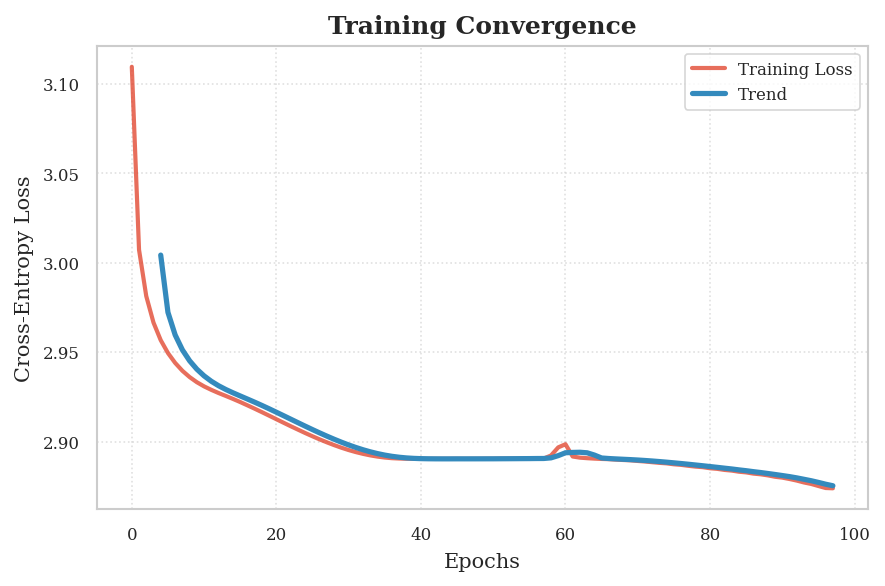

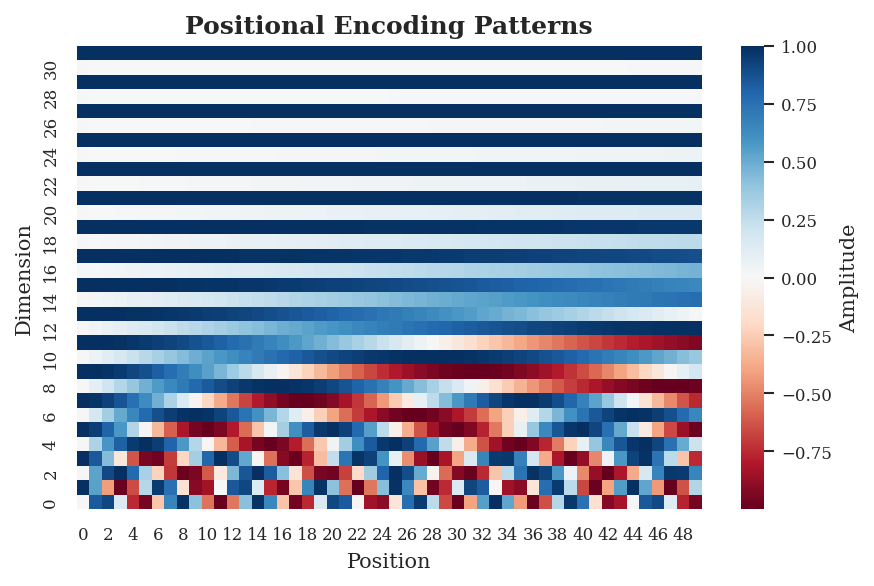

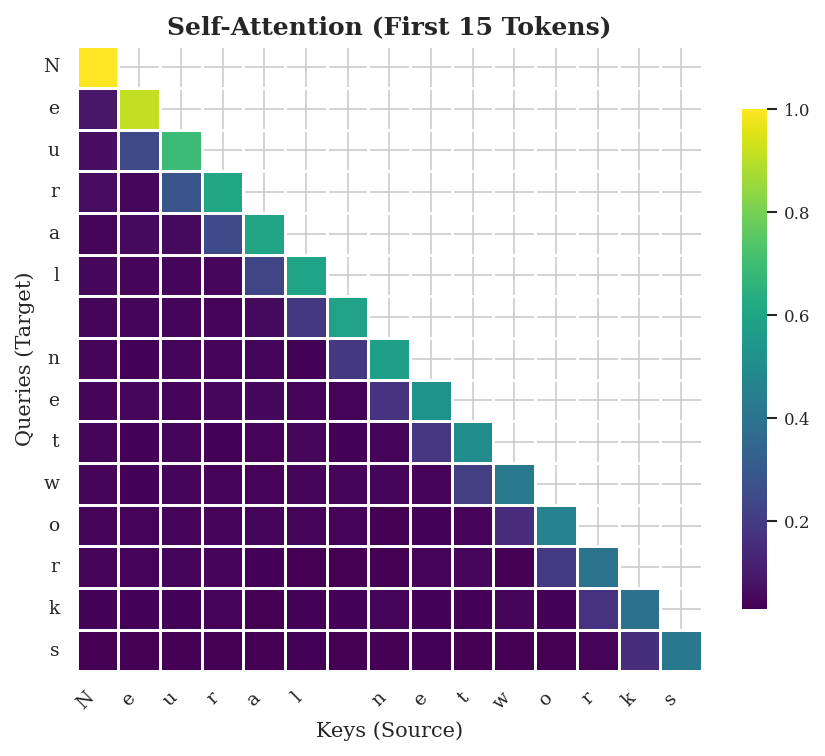

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 150
})

plt.figure(figsize=(6, 4))

clean_history = loss_history[:-2] if len(loss_history) > 5 else loss_history

plt.plot(clean_history, label='Training Loss', color='#E24A33', linewidth=2, alpha=0.8)

if len(clean_history) > 5:
    w = 5
    smoothed = np.convolve(clean_history, np.ones(w)/w, mode='valid')
    plt.plot(range(w-1, len(clean_history)), smoothed,
             color='#348ABD', linewidth=2.5, label='Trend')

plt.title('Training Convergence', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(frameon=True, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('01_training_loss_fixed.png', dpi=300, bbox_inches='tight')
plt.show()


def get_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model))
    position = np.arange(0, max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

pe_matrix = get_positional_encoding(50, 32)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(pe_matrix.T, cmap='RdBu', center=0, cbar_kws={'label': 'Amplitude'})
ax.invert_yaxis()
plt.title('Positional Encoding Patterns', fontweight='bold')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.tight_layout()
plt.savefig('02_positional_encoding.png', dpi=300, bbox_inches='tight')
plt.show()


ZOOM_LEN = 15

labels = [tokenizer.id2token[t] for t in tokens][:ZOOM_LEN]
seq_len = len(labels)

att_matrix = np.zeros((seq_len, seq_len))
for i in range(seq_len):
    raw_scores = np.random.normal(0, 0.1, size=i+1)
    raw_scores[-1] += 2.5
    if i > 1: raw_scores[-2] += 1.5

    exps = np.exp(raw_scores)
    probs = exps / np.sum(exps)
    att_matrix[i, :i+1] = probs

plt.figure(figsize=(6, 5))

mask = np.triu(np.ones_like(att_matrix, dtype=bool), k=1)

sns.heatmap(att_matrix, mask=mask, cmap='viridis',
            xticklabels=labels, yticklabels=labels,
            square=True, cbar_kws={'shrink': 0.8},
            linewidths=0.5, linecolor='white',
            annot=False)

plt.title(f'Self-Attention (First {ZOOM_LEN} Tokens)', fontweight='bold')
plt.xlabel('Keys (Source)')
plt.ylabel('Queries (Target)')

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('03_attention_map_zoom.png', dpi=300, bbox_inches='tight')
plt.show()